<a href="https://colab.research.google.com/github/codekulturbonn/klimadiagramme/blob/main/Klimadiagramme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Klimadiagramme
In Erdkunde habt ihr gerade Klimadiagramme durchgenommen. Im Buch _Terra 2_ ist auf Seite 33 das Diagramm für die Messstation in _Malaga_ abgebildet.

Zusätzlich sind auf Seite 216 die monatlichen Durschnittstemperaturen und durschnittlichen Niederschlagsmengen einiger Klimastationen aufgelistet.

Auf der [Wikipedia-Seite zu Klimadiagramm](https://de.wikipedia.org/wiki/Klimadiagramm) finden sich weitere Beispiele.

In diesem Notebook wollen wir uns anschauen, wie man die Daten weiterer Stationen aus dem Angebot des Deutschen Wetterdienstes _DWD_ mit Sitz in Hamburg herunterladen und daraus per Script automatisch Klimadiagramme erstellen kann. 

Der DWD bietet viele unterschiedliche Daten an. Es gibt z.B. eine Tabelle zu Klimadaten von Wetterstationen für einzelne Monate.

Wir brauchen die Daten aber maschinenlesbar und über alle Monate eines Jahres, um daraus ein Klimadiagramm zeichnen zu können. Der DWD bietet neben den vorformatierten Daten auch [Datensätze für Hobbymeteorologen](https://www.dwd.de/DE/leistungen/cdc/cdc_ueberblick-klimadaten.html) in seinem _Open Data_-Bereich am. Die Bedeutung der Spalten in der Datentabelle sind in einer [herunterladbaren PDF-Datei](https://opendata.dwd.de/climate_environment/CDC/observations_global/CLIMAT/monthly/raw/BESCHREIBUNG_obsglobal_monthly_raw_de.pdf) beschrieben.

Zunächst einige globale Daten:

In [ ]:
import csv
import requests

station_name = 'Koeln/Bonn'
#station_name = 'Bonn-Roleber'
year = 2020

stations_url = 'https://opendata.dwd.de/climate_environment/CDC/help/stations_list_CLIMAT_data.txt'
data_url = 'https://opendata.dwd.de/climate_environment/CDC/observations_global/CLIMAT/monthly/raw/CLIMAT_RAW_{year}{month:02d}.txt'

## Stationsdaten
Zunächst laden wir die Daten der Stationen in eine Variable _stations_. Jede Station hat einen Kürzel, einen Namen und weitere Daten.

Wir speichern die Stationen als _Dictionary_, in dem wir nach Stationsnamen suchen können.

In [ ]:
r = requests.get(stations_url)
reader = csv.DictReader(r.text.splitlines(), delimiter=';', skipinitialspace=True)
stations = { station['StationName']: dict(station) for station in list(reader) }
print(stations)

{'Jan Mayen': {'WMO-Station ID': '01001', 'StationName': 'Jan Mayen', 'Latitude': '70.94', 'Longitude': '-08.67', 'Height': '9', 'Country': 'Norway                                         '}, 'Isfjord Radio': {'WMO-Station ID': '01005', 'StationName': 'Isfjord Radio', 'Latitude': '78.06', 'Longitude': '13.63', 'Height': '9', 'Country': 'Norway                                         '}, 'Ny-Alesund': {'WMO-Station ID': '01007', 'StationName': 'Ny-Alesund', 'Latitude': '78.92', 'Longitude': '11.93', 'Height': '8', 'Country': 'Norway                                         '}, 'Svalbard': {'WMO-Station ID': '01008', 'StationName': 'Svalbard', 'Latitude': '78.25', 'Longitude': '15.50', 'Height': '27', 'Country': 'Norway                                         '}, 'Tromso/Langnes': {'WMO-Station ID': '01025', 'StationName': 'Tromso/Langnes', 'Latitude': '69.68', 'Longitude': '18.91', 'Height': '9', 'Country': 'Norway                                         '}, 'Tromso': {'WMO-Station ID': 

## Klimadaten
Anschliessend laden wir die Klimadaten, Monat für Monat und filtern jeweils die Daten für die gewünschte Station. 

Da wir die Station nach ihrem Kürzel suchen, legen wir die Daten der einzelnen Stationen gleich als _Dictionary_ mit dem Kürzel als Schlüssel an.

Es gibt leider noch eine Schwierigkeit. Die Spaltennamen in den Daten sind nicht eindeutig, daher könen wir keinen _DictReader_ verwenden. Wir folgen einem [Vorschlag auf Stackoverflow](https://stackoverflow.com/a/31771695/125395), nutzen einen einfachen _reader_ und machen die Spaltennamen in einer Funktion _remap_ durch Anhängen einer Zahl eindeutig.

Hier ist die Funktion _remap_ mit einem Beispiel ihrer Funktion: 

In [ ]:
def remap(fieldnames):
  newnames = []
  for f in fieldnames:
    if f in newnames:
      occurrences = list(filter(lambda x: x.startswith(f), newnames))
      newnames.append(f + (len(occurrences) + 1).__str__())
    else:
      newnames.append(f)
  return newnames

beispiel = ['a', 'b', 'a', 'b1', 'b', 'b1']
print(remap(beispiel)) 


['a', 'b', 'a2', 'b1', 'b3', 'b12']


Wie sammeln nur die Daten unserer einen Station in der Variable _months_. Die Daten aller anderen Stationen verwerfen wir.

In [ ]:
station = stations[station_name]
station_id = station['WMO-Station ID']

months = {}
for month in range(1, 12):
  r = requests.get(data_url.format(year=year, month=month))
  reader = csv.reader(r.text.splitlines(), delimiter=';')
  fieldnames = remap(next(reader))
  data = {}
  for row in list(reader):
    station_data = dict(zip(fieldnames, row))
    if station_data['IIiii'] == station_id:
      months[f'{month:02d}'] = dict(
          t=station_data['T'], 
          sn=-1 if station_data['sn'] == '1' else 1,
          mm=station_data['R1']
      )
      break
print(months)

{'01': {'t': '053', 'sn': 1, 'mm': '0042'}, '02': {'t': '069', 'sn': 1, 'mm': '0103'}, '03': {'t': '075', 'sn': 1, 'mm': '0086'}, '04': {'t': '125', 'sn': 1, 'mm': '0019'}, '05': {'t': '135', 'sn': 1, 'mm': '0013'}, '06': {'t': '181', 'sn': 1, 'mm': '0082'}, '07': {'t': '183', 'sn': 1, 'mm': '0047'}, '08': {'t': '213', 'sn': 1, 'mm': '0108'}, '09': {'t': '158', 'sn': 1, 'mm': '0054'}, '10': {'t': '116', 'sn': 1, 'mm': '0092'}, '11': {'t': '089', 'sn': 1, 'mm': '0037'}}


## Klimadiagramm
Jetzt haben wir alle Daten zusammen, um unser Klimadiagram zu zeichnen. Wir benutzen dazu die Grafikbibliothek [mathplotlib](https://matplotlib.org/2.0.2/gallery.html).

[5.300000000000001, 6.9, 7.5, 12.5, 13.5, 18.1, 18.3, 21.3, 15.8, 11.600000000000001, 8.9]
[42, 103, 86, 19, 13, 82, 47, 108, 54, 92, 37]


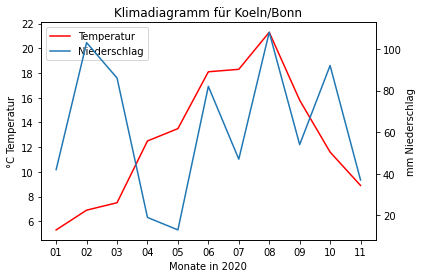

In [ ]:
import matplotlib

x = list(months.keys())
t = [ int(m['t']) * m['sn'] * 0.1 for m in months.values() ]
print(t)
mm = [ int(m['mm']) for m in months.values() ]
print(mm)

fig1 = matplotlib.figure.Figure()

x1 = fig1.add_subplot()
h1, = x1.plot(x, t, label="Temperatur", color="red")
x1.set_ylabel("°C Temperatur")
x1.set_xlabel(f'Monate in {year}')

x2 = x1.twinx()
h2, = x2.plot(x, mm, label="Niederschlag")
x2.set_ylabel("mm Niederschlag")

x1.set_title(f'Klimadiagramm für {station_name}')
x1.legend(handles=(h1, h2))

display(fig1)